In [1]:
import numpy as np
import os
import sys
import glob
import uproot as ur
import matplotlib.pyplot as plt
import time
import seaborn as sns
import tensorflow as tf
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.graphs import GraphsTuple
import sonnet as snt
import argparse
import yaml
import logging
import tensorflow as tf

from gn4pions.modules.data import GraphDataGenerator
from gn4pions.modules.models import MultiOutWeightedRegressModel
from gn4pions.modules.utils import convert_to_tuple

sns.set_context('poster')

In [2]:
# Loading model config
config_file = 'gn4pions/configs/weightedRegress.yaml'
config = yaml.load(open(config_file), Loader=yaml.FullLoader)

# Data config
data_config = config['data']

data_dir = data_config['data_dir']
num_train_files = data_config['num_train_files']
num_val_files = data_config['num_val_files']
batch_size = data_config['batch_size']
shuffle = data_config['shuffle']
num_procs = data_config['num_procs']
preprocess = data_config['preprocess']
output_dir = data_config['output_dir']
already_preprocessed = data_config['already_preprocessed']  # Set to false when running training for first time

# Model Config
model_config = config['model']

concat_input = model_config['concat_input']


# Traning Config
train_config = config['training']

epochs = train_config['epochs']
learning_rate = train_config['learning_rate']
alpha = train_config['alpha']
os.environ['CUDA_VISIBLE_DEVICES'] = str(train_config['gpu'])
log_freq = train_config['log_freq']
save_dir = train_config['save_dir'] + config_file.replace('.yaml','').split('/')[-1] + '_' + time.strftime("%Y%m%d")

os.makedirs(save_dir, exist_ok=True)
yaml.dump(config, open(save_dir + '/config.yaml', 'w'))


In [3]:
# Read data and create data generators

pi0_files = np.sort(glob.glob(data_dir+'*pi0*/*root'))
pion_files = np.sort(glob.glob(data_dir+'*pion*/*root'))

train_start = 0
train_end = train_start + num_train_files
val_end = train_end + num_val_files

pi0_train_files = pi0_files[train_start:train_end]
pi0_val_files = pi0_files[train_end:val_end]
pion_train_files = pion_files[train_start:train_end]
pion_val_files = pion_files[train_end:val_end]

train_output_dir = None
val_output_dir = None

# Get Data
if preprocess:
    train_output_dir = output_dir + '/train/'
    val_output_dir = output_dir + '/val/'

    if already_preprocessed:
        train_files = np.sort(glob.glob(train_output_dir+'*.p'))[:num_train_files]
        val_files = np.sort(glob.glob(val_output_dir+'*.p'))[:num_val_files]

        pi0_train_files = train_files
        pi0_val_files = val_files
        pion_train_files = None
        pion_val_files = None

        train_output_dir = None
        val_output_dir = None

# Traning Data Generator
# Will preprocess data if it doesnt find pickled files
data_gen_train = GraphDataGenerator(pi0_file_list=pi0_train_files,
                                    pion_file_list=pion_train_files,
                                    cellGeo_file=data_dir+'CellGeo.neighbours.root',
                                    batch_size=batch_size,
                                    shuffle=shuffle,
                                    num_procs=num_procs,
                                    preprocess=preprocess,
                                    output_dir=train_output_dir)

# Validation Data generator
# Will preprocess data if it doesnt find pickled files
data_gen_val = GraphDataGenerator(pi0_file_list=pi0_val_files,
                                  pion_file_list=pion_val_files,
                                  cellGeo_file=data_dir+'CellGeo.neighbours.root',
                                  batch_size=batch_size,
                                  shuffle=shuffle,
                                  num_procs=num_procs,
                                  preprocess=preprocess,
                                  output_dir=val_output_dir)


In [4]:
# Get batch of data
def get_batch(data_iter):
    for graphs, targets in data_iter:
        graphs = convert_to_tuple(graphs)
        targets = tf.convert_to_tensor(targets)
        yield graphs, targets
        
# Define loss function        
mae_loss = tf.keras.losses.MeanAbsoluteError()
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def loss_fn(targets, regress_preds, class_preds):
    regress_loss = mae_loss(targets[:,:1], regress_preds)
    class_loss = bce_loss(targets[:,1:], class_preds)
    combined_loss = alpha*regress_loss + (1 - alpha)*class_loss 
    return regress_loss, class_loss, combined_loss

In [5]:
# Get a sample graph for tf.function decorator
samp_graph, samp_target = next(get_batch(data_gen_train.generator()))
data_gen_train.kill_procs()
graph_spec = utils_tf.specs_from_graphs_tuple(samp_graph, True, True, True)

# Traning set
@tf.function(input_signature=[graph_spec, tf.TensorSpec(shape=[None,2], dtype=tf.float32)])
def train_step(graphs, targets):
    with tf.GradientTape() as tape:
        regress_output, class_output = model(graphs)
        regress_preds = regress_output.globals
        class_preds = class_output.globals
        regress_loss, class_loss, loss = loss_fn(targets, regress_preds, class_preds)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return regress_loss, class_loss, loss

# Validation Step
@tf.function(input_signature=[graph_spec, tf.TensorSpec(shape=[None,2], dtype=tf.float32)])
def val_step(graphs, targets):
    regress_output, class_output = model(graphs)
    regress_preds = regress_output.globals
    class_preds = class_output.globals
    regress_loss, class_loss, loss = loss_fn(targets, regress_preds, class_preds)
    return regress_loss, class_loss, loss, regress_preds, class_preds

2021-12-10 02:16:06.471277: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-10 02:16:07.010565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19934 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
# Model 
model = MultiOutWeightedRegressModel(global_output_size=1, num_outputs=2, model_config=model_config)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Average epoch losses
training_loss_epoch = []
training_loss_regress_epoch = []
training_loss_class_epoch = []
val_loss_epoch = []
val_loss_regress_epoch = []
val_loss_class_epoch = []

# Model checkpointing, load latest model if available
checkpoint = tf.train.Checkpoint(module=model)
checkpoint_prefix = os.path.join(save_dir, 'latest_model')
latest = tf.train.latest_checkpoint(save_dir)
if latest is not None:
    checkpoint.restore(latest)
else:
    checkpoint.save(checkpoint_prefix)

In [7]:
# Run training
curr_loss = 1e5

for e in range(epochs):

    print(f'\n\nStarting epoch: {e}')
    epoch_start = time.time()
    
    # Batchwise losses
    training_loss = []
    training_loss_regress = []
    training_loss_class = []
    val_loss = []
    val_loss_regress = []
    val_loss_class = []

    # Train
    print('Training...')
    start = time.time()
    for i, (graph_data_tr, targets_tr) in enumerate(get_batch(data_gen_train.generator())):
        losses_tr_rg, losses_tr_cl, losses_tr = train_step(graph_data_tr, targets_tr)

        training_loss.append(losses_tr.numpy())
        training_loss_regress.append(losses_tr_rg.numpy())
        training_loss_class.append(losses_tr_cl.numpy())

        if not (i-1)%log_freq:
            end = time.time()
            print(f'Iter: {i:04d}, ', end='')
            print(f'Tr_loss_mean: {np.mean(training_loss):.4f}, ', end='')
            print(f'Tr_loss_rg_mean: {np.mean(training_loss_regress):.4f}, ', end='') 
            print(f'Tr_loss_cl_mean: {np.mean(training_loss_class):.4f}, ', end='') 
            print(f'Took {end-start:.4f}secs')
            start = time.time()
                  
    training_loss_epoch.append(training_loss)
    training_loss_regress_epoch.append(training_loss_regress)
    training_loss_class_epoch.append(training_loss_class)
    training_end = time.time()

    # validate
    print('\nValidation...')
    all_targets = []
    all_outputs = []
    start = time.time()
    for i, (graph_data_val, targets_val) in enumerate(get_batch(data_gen_val.generator())):
        losses_val_rg, losses_val_cl, losses_val, regress_vals, class_vals = val_step(graph_data_val, targets_val)

        targets_val = targets_val.numpy()
        regress_vals = regress_vals.numpy()
        class_vals = class_vals.numpy()

        targets_val[:,0] = 10**targets_val[:,0]
        regress_vals = 10**regress_vals
        class_vals =  tf.math.sigmoid(class_vals)

        output_vals = np.hstack([regress_vals, class_vals])

        val_loss.append(losses_val.numpy())
        val_loss_regress.append(losses_val_rg.numpy())
        val_loss_class.append(losses_val_cl.numpy())

        all_targets.append(targets_val)
        all_outputs.append(output_vals)

        if not (i-1)%log_freq:
            end = time.time()
            print(f'Iter: {i:04d}, ', end='')
            print(f'Val_loss_mean: {np.mean(val_loss):.4f}, ', end='')
            print(f'Val_loss_rg_mean: {np.mean(val_loss_regress):.4f}, ', end='') 
            print(f'Val_loss_cl_mean: {np.mean(val_loss_class):.4f}, ', end='') 
            print(f'Took {end-start:.4f}secs')
            start = time.time()

    epoch_end = time.time()

    all_targets = np.concatenate(all_targets)
    all_outputs = np.concatenate(all_outputs)

    val_loss_epoch.append(val_loss)
    val_loss_regress_epoch.append(val_loss_regress)
    val_loss_class_epoch.append(val_loss_class)

    
    # Book keeping
    val_mins = int((epoch_end - training_end)/60)
    val_secs = int((epoch_end - training_end)%60)
    training_mins = int((training_end - epoch_start)/60)
    training_secs = int((training_end - epoch_start)%60)
    print(f'\nEpoch {e} ended')
    print(f'Training: {training_mins:2d}:{training_secs:02d}')
    print(f'Validation: {val_mins:2d}:{val_secs:02d}')
    
    
    # Save losses
    np.savez(save_dir+'/losses', 
            training=training_loss_epoch, validation=val_loss_epoch,
            training_regress=training_loss_regress_epoch, validation_regress=val_loss_regress_epoch,
            training_class=training_loss_class_epoch, validation_class=val_loss_class_epoch,
            )

    
    # Checkpoint if validation loss improved
    if np.mean(val_loss)<curr_loss:
        print(f'Loss decreased from {curr_loss:.4f} to {np.mean(val_loss):.4f}')
        print(f'Checkpointing and saving predictions to:\n{save_dir}')
        curr_loss = np.mean(val_loss)
        np.savez(save_dir+'/predictions', 
                targets=all_targets, 
                outputs=all_outputs)
        checkpoint.save(checkpoint_prefix)
    else: 
        print(f'Loss didnt decrease from {curr_loss:.4f}')
    
    
    # Decrease learning rate every few epochs
    if not (e+1)%2:   #%20:
        optimizer.learning_rate = optimizer.learning_rate/10
        print(f'Learning rate decreased to: {optimizer.learning_rate.value():.3e}')



Starting epoch: 0
Training...


2021-12-10 02:16:14.504943: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/MultiOutWeightedRegressModel/core_3/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/MultiOutWeightedRegressModel/core_3/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/MultiOutWeightedRegressModel/core_3/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/global/home/users/mfong/anaconda3

Iter: 0001, Tr_loss_mean: 1.0850, Tr_loss_rg_mean: 1.1000, Tr_loss_cl_mean: 1.0400, Took 12.3535secs
Iter: 0101, Tr_loss_mean: 0.3919, Tr_loss_rg_mean: 0.2299, Tr_loss_cl_mean: 0.8777, Took 16.9571secs
Iter: 0201, Tr_loss_mean: 0.3343, Tr_loss_rg_mean: 0.1841, Tr_loss_cl_mean: 0.7847, Took 16.4486secs
Iter: 0301, Tr_loss_mean: 0.3069, Tr_loss_rg_mean: 0.1631, Tr_loss_cl_mean: 0.7383, Took 16.8972secs
Iter: 0401, Tr_loss_mean: 0.2878, Tr_loss_rg_mean: 0.1477, Tr_loss_cl_mean: 0.7081, Took 17.0514secs
Iter: 0501, Tr_loss_mean: 0.2761, Tr_loss_rg_mean: 0.1419, Tr_loss_cl_mean: 0.6785, Took 17.0652secs
Iter: 0601, Tr_loss_mean: 0.2619, Tr_loss_rg_mean: 0.1338, Tr_loss_cl_mean: 0.6462, Took 16.9495secs
Iter: 0701, Tr_loss_mean: 0.2500, Tr_loss_rg_mean: 0.1280, Tr_loss_cl_mean: 0.6161, Took 16.4990secs
Iter: 0801, Tr_loss_mean: 0.2415, Tr_loss_rg_mean: 0.1251, Tr_loss_cl_mean: 0.5905, Took 16.5003secs
Iter: 0901, Tr_loss_mean: 0.2328, Tr_loss_rg_mean: 0.1214, Tr_loss_cl_mean: 0.5671, Took 16

Iter: 0401, Tr_loss_mean: 0.1157, Tr_loss_rg_mean: 0.0702, Tr_loss_cl_mean: 0.2524, Took 16.5741secs
Iter: 0501, Tr_loss_mean: 0.1156, Tr_loss_rg_mean: 0.0701, Tr_loss_cl_mean: 0.2521, Took 16.4680secs
Iter: 0601, Tr_loss_mean: 0.1155, Tr_loss_rg_mean: 0.0701, Tr_loss_cl_mean: 0.2517, Took 16.5685secs
Iter: 0701, Tr_loss_mean: 0.1153, Tr_loss_rg_mean: 0.0702, Tr_loss_cl_mean: 0.2509, Took 16.4824secs
Iter: 0801, Tr_loss_mean: 0.1152, Tr_loss_rg_mean: 0.0701, Tr_loss_cl_mean: 0.2506, Took 16.3107secs
Iter: 0901, Tr_loss_mean: 0.1152, Tr_loss_rg_mean: 0.0701, Tr_loss_cl_mean: 0.2506, Took 16.4868secs
Iter: 1001, Tr_loss_mean: 0.1152, Tr_loss_rg_mean: 0.0700, Tr_loss_cl_mean: 0.2507, Took 16.5342secs

Validation...
Iter: 0001, Val_loss_mean: 0.1135, Val_loss_rg_mean: 0.0674, Val_loss_cl_mean: 0.2517, Took 2.7677secs
Iter: 0101, Val_loss_mean: 0.1144, Val_loss_rg_mean: 0.0696, Val_loss_cl_mean: 0.2488, Took 9.8116secs
Iter: 0201, Val_loss_mean: 0.1147, Val_loss_rg_mean: 0.0702, Val_loss_cl

Iter: 0801, Tr_loss_mean: 0.1144, Tr_loss_rg_mean: 0.0697, Tr_loss_cl_mean: 0.2485, Took 16.5854secs
Iter: 0901, Tr_loss_mean: 0.1144, Tr_loss_rg_mean: 0.0698, Tr_loss_cl_mean: 0.2484, Took 16.2291secs
Iter: 1001, Tr_loss_mean: 0.1144, Tr_loss_rg_mean: 0.0697, Tr_loss_cl_mean: 0.2486, Took 16.3906secs

Validation...
Iter: 0001, Val_loss_mean: 0.1199, Val_loss_rg_mean: 0.0714, Val_loss_cl_mean: 0.2655, Took 2.7439secs
Iter: 0101, Val_loss_mean: 0.1140, Val_loss_rg_mean: 0.0694, Val_loss_cl_mean: 0.2475, Took 9.9971secs
Iter: 0201, Val_loss_mean: 0.1141, Val_loss_rg_mean: 0.0700, Val_loss_cl_mean: 0.2466, Took 9.8031secs
Iter: 0301, Val_loss_mean: 0.1144, Val_loss_rg_mean: 0.0699, Val_loss_cl_mean: 0.2481, Took 9.7868secs
Iter: 0401, Val_loss_mean: 0.1145, Val_loss_rg_mean: 0.0699, Val_loss_cl_mean: 0.2485, Took 9.3809secs
Iter: 0501, Val_loss_mean: 0.1148, Val_loss_rg_mean: 0.0701, Val_loss_cl_mean: 0.2488, Took 9.4352secs

Epoch 8 ended
Training:  3:05
Validation:  0:55
Loss decreased 

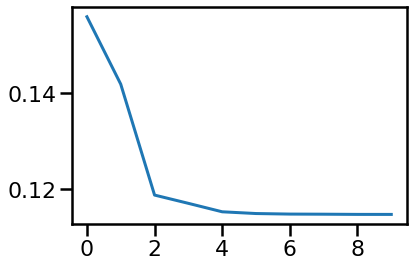

In [13]:
plt.plot([np.mean(x) for x in val_loss_epoch])